<span style="font-family:Helvetica Light">
    
# Data Prep


## The goal of this notebook:
The goal of this notebook is to:
* import the Streaming History requested from Spotify, 
* merge it into 1 data frame, 
* add needed date and time related transformations 
* connect to the Spotify API using Spotipy library in order to extend my dataset with track details and audio features 

## About obtaining user's data
Spotify allows its users to get a copy of one year worth of their streaming history. To get your own simply <a href="https://www.spotify.com/us/account/privacy/" target="_blank">click here</a> and scroll down and follow the steps. 

## About Spotipy Library
From the <a href="https://spotipy.readthedocs.io/" target="_blank">Spotipy documentation</a>:

<blockquote>Spotipy is a lightweight Python library for the Spotify Web API. With Spotipy you get full access to all of the music data provided by the Spotify platform.</blockquote>

In this notebook following <a href="https://spotipy.readthedocs.io/en/2.19.0/#api-reference" target="_blank">API references functions</a> were used in order to get endpoints listed below:
* search(_q, limit=10, offset=0, type='track', market=None_) - used types: _track, show, episode_
* audio_features(_tracks=[]_)
* artists(artists(_ids))

## About Spotify API
From the <a href="https://developer.spotify.com/documentation/web-api/" target="_blank">Spotipy documentation</a>:

<blockquote>the Spotify Web API endpoints return JSON metadata about music artists, albums, and tracks, directly from the Spotify Data Catalogue. [...] Web API also provides access to user related data, like playlists and music that the user saves in the Your Music library. Such access is enabled through selective authorization, by the user.</blockquote>

In this notebook following endpoints were used:
* <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/search" target="_blank">search</a>
* <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features" target="_blank">audio features</a>
* <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/get-multiple-artists" target="_blank">artists</a>


The list of all available endpoints references can be found <a href="https://developer.spotify.com/documentation/web-api/reference/#/" target="_blank">here</a>.

### References:
1. https://github.com/tgel0/spotify-data/blob/master/notebooks/SpotifyDataRetrieval.ipynb


</span>

<span style="font-family:Helvetica Light">
    
# 1. Set-up & Data Loading
    
Loading neccessary libraries.
    
Loading the json files from the requested data sent by Spotify.
    
</span>

In [1]:
import pandas as pd

from datetime import datetime
from pytz import timezone

import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import timeit

In [2]:
data_dir = '/Users/Karolina/ProjectsDataScience/data_science_environment/data/'
file_list = ['MyDataSpotify/StreamingHistory0.json',
             'MyDataSpotify/StreamingHistory1.json',
             'MyDataSpotify/StreamingHistory2.json',
             'MyDataSpotify/StreamingHistory3.json',
             'MyDataSpotify/StreamingHistory4.json',
             'MyDataSpotify/StreamingHistory5.json',
             'MyDataSpotify/StreamingHistory6.json']

dfs = [] # an empty list to store the data frames
for file in file_list:
    data = pd.read_json(data_dir+file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63060 entries, 0 to 63059
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     63060 non-null  object
 1   artistName  63060 non-null  object
 2   trackName   63060 non-null  object
 3   msPlayed    63060 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


<span style="font-family:Helvetica Light">
    
# 2. Quick EDA

In this step I check how the dataframe looks like.

As I also loaded data from 2 seperate request, I expect there will be some duplicates. That needs to be checked for and cleaned.
    
</span>

In [3]:
df.head()

,endTime,artistName,trackName,msPlayed
0,2020-11-21 08:21,"Does It Offend You, Yeah?",We Are Rockstars,13744
1,2020-11-21 08:25,"Does It Offend You, Yeah?",With A Heavy Heart (I Regret To Inform You),256170
2,2020-11-21 08:27,"Does It Offend You, Yeah?",We Are Rockstars,69343
3,2020-11-21 08:30,"Does It Offend You, Yeah?",Doomed Now,221133
4,2020-11-21 08:31,"Does It Offend You, Yeah?",Being Bad Feels Pretty Good,2603


In [4]:
# checking for duplicates
df.duplicated().sum()

4007

In [5]:
# remove duplicates
df.drop_duplicates(inplace=True)

# double checking for duplicates
df.duplicated().sum()

0

<span style="font-family:Helvetica Light">
    
With the duplicates removed, getting basic information about the data frame.

Changing the first column to datetime object for further calculations.

</span>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59053 entries, 0 to 63059
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     59053 non-null  object
 1   artistName  59053 non-null  object
 2   trackName   59053 non-null  object
 3   msPlayed    59053 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


<span style="font-family:Helvetica Light">
    
Running a quick check on the listening history over the course of the day to establish the timezone.
    
Based on my habits, it is highly unlikely that I listen the music at 5am and 6am. This indicates that the timezone is not the one I live in: it seems the data are based on the UTC, whereas I live in the Europe/Berlin timezone.
    
</span>    

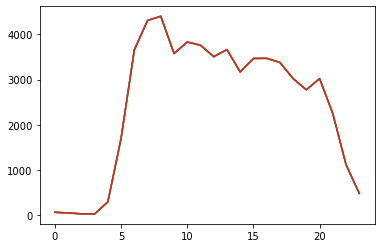

In [7]:
df.endTime = pd.to_datetime(df.endTime) 

freq = df.groupby(df['endTime'].dt.hour).count()
plt.plot(freq)
plt.show()

<span style="font-family:Helvetica Light">

# 3. Dates & Time Transformations
    
In this step I change the _endTime_ column from UTC timezone to Europe/Berlin.
    
Additional columns are crated based on the _endTime_ and _msPlayed_ columns:
* hour
* date (with no timestamp)
* week start date
* month start date
* seconds played   
* minutes played   
* hours played   
    
</span>   

In [1]:
# set the current time to UTC timezone
df['endTimeTz']= df.endTime.dt.tz_localize(tz='UTC')

# convert US Pacific to Europe/Berlin Timezone
df['endTimeTzEU']=df.endTimeTz.dt.tz_convert(tz='Europe/Berlin')

df['endTime']=df['endTimeTzEU'].apply(lambda d: d.replace(tzinfo=None))

df.drop(['endTimeTz', 'endTimeTzEU'], axis=1, inplace=True)

# additional time related transofmations 
df['hour'] = df['endTime'].dt.hour
df['date'] = df['endTime'].dt.to_period('D').apply(lambda r: r.start_time)
df['week'] = df['endTime'].dt.to_period('W').apply(lambda r: r.start_time)
df['month'] = df['endTime'].dt.to_period('M').apply(lambda r: r.start_time)

# rounding up miliseconds Played to more readable formats
df['sPlayed'] = df['msPlayed']/(1000)
df['mPlayed'] = df['sPlayed']/(60)
df['hPlayed'] = df['sPlayed']/(60*60)

df.head()

NameError: name 'pd' is not defined

<span style="font-family:Helvetica Light">

Checking the description of the _endTime_ feature. 

Some data collection still accounts for 2020 and 2022 data. Let's remove it in order to keep only full 2021.


</span>

In [9]:
df.endTime.describe()

<ipython-input-9-38a75eb175bd>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.endTime.describe()


count                   59053
unique                  44585
top       2020-12-14 22:40:00
freq                       35
first     2020-11-21 09:21:00
last      2022-02-17 22:15:00
Name: endTime, dtype: object

In [10]:
df = df.loc[df['endTime'].dt.year == 2021].reset_index(drop=True)

<span style="font-family:Helvetica Light">

Sorting the dataframe by the _endTime_ to see first and last streamed songs of 2021.
    
<span>

In [11]:
df.sort_values(by='endTime', inplace=True)
df.head(3)

,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,hPlayed
0,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,44827,6,2021-01-01,2020-12-28,2021-01-01,44.827,0.747117,0.012452
1,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,31750,6,2021-01-01,2020-12-28,2021-01-01,31.750,0.529167,0.008819
2,2021-01-01 06:04:00,Justin Bieber,Anyone,190779,6,2021-01-01,2020-12-28,2021-01-01,190.779,3.179650,0.052994


In [12]:
df.tail(3)

,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,hPlayed
45082,2021-12-31 13:43:00,Future,F*ck Up Some Commas,108580,13,2021-12-31,2021-12-27,2021-12-01,108.580,1.809667,0.030161
45083,2021-12-31 13:45:00,Lifespan with Dr. David Sinclair,Welcome to Lifespan with Dr. David Sinclair,96693,13,2021-12-31,2021-12-27,2021-12-01,96.693,1.611550,0.026859
45084,2021-12-31 16:08:00,Huberman Lab,Dr. David Sinclair: The Biology of Slowing & R...,5119830,16,2021-12-31,2021-12-27,2021-12-01,5119.830,85.330500,1.422175


In [13]:
minutes_played = df.mPlayed.sum()
print(f'Minutes played in 2021: '+'{:,.2f}'.format(minutes_played))

Minutes played in 2021: 103,954.59


<span style="font-family:Helvetica Light">

# 4. Spotify API Connector with Spotipy library

In order to connect to Spotify API, Client ID and Secret Client ID are needed. In order to get those two keys, it is neccessary to <a href="https://developer.spotify.com/documentation/general/guides/authorization/app-settings/" target="_blank">set up an App in the Spotify for Developers platform</a>.

<blockquote>
The app provides, among others, the Client ID and Client Secret needed to implement any of the authorization flows.
    </blockquote>
    
Next, once we have the Client Credentials, the Client Authorization Code Flow can be initialized.

    
## 4.1. Connection & sample request
</span>

In [72]:
client_id = 'xxx'
secret_client_id = 'xxx'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=secret_client_id)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

<span style="font-family:Helvetica Light">

In this part I am picking one piece of data to see what is the structure of results I get using search query and audio features call:
    
</span>    

In [101]:
# simple check on one piece of data
artistName = 'Sabrina Claudio'
trackName = 'Numb'
searchQuery = trackName + ' ' + artistName
searchResults = sp.search(q=searchQuery, market="DE", limit=2, type='track')
searchResults

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=Numb+Sabrina+Claudio&type=track&market=DE&offset=0&limit=2',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/30DhU7BDmF4PH0JVhu8ZRg'},
       'href': 'https://api.spotify.com/v1/artists/30DhU7BDmF4PH0JVhu8ZRg',
       'id': '30DhU7BDmF4PH0JVhu8ZRg',
       'name': 'Sabrina Claudio',
       'type': 'artist',
       'uri': 'spotify:artist:30DhU7BDmF4PH0JVhu8ZRg'},
      {'external_urls': {'spotify': 'https://open.spotify.com/artist/7mnuMLgvXdCWzyB4sQCG7k'},
       'href': 'https://api.spotify.com/v1/artists/7mnuMLgvXdCWzyB4sQCG7k',
       'id': '7mnuMLgvXdCWzyB4sQCG7k',
       'name': 'TWO LANES',
       'type': 'artist',
       'uri': 'spotify:artist:7mnuMLgvXdCWzyB4sQCG7k'}],
     'external_urls': {'spotify': 'https://open.spotify.com/album/6GnDqI4jkf4DtxKfzuqj1K'},
     'href': 'https://api.spotify.com/v1/albums/6GnDqI4jkf4DtxKfzuqj1K',
     'id':

In [74]:
track_id = searchResults['tracks']['items'][0]['id']
sp.audio_features(tracks=[track_id])

[{'danceability': 0.572,
  'energy': 0.631,
  'key': 7,
  'loudness': -9.836,
  'mode': 0,
  'speechiness': 0.0476,
  'acousticness': 0.222,
  'instrumentalness': 0,
  'liveness': 0.135,
  'valence': 0.0713,
  'tempo': 134.078,
  'type': 'audio_features',
  'id': '4PhsKqMdgMEUSstTDAmMpg',
  'uri': 'spotify:track:4PhsKqMdgMEUSstTDAmMpg',
  'track_href': 'https://api.spotify.com/v1/tracks/4PhsKqMdgMEUSstTDAmMpg',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4PhsKqMdgMEUSstTDAmMpg',
  'duration_ms': 249040,
  'time_signature': 4}]

In [18]:
artist_id = searchResults['tracks']['items'][0]['artists'][0]['id']
sp.artist(artist_id)

{'external_urls': {'spotify': 'https://open.spotify.com/artist/1Xyo4u8uXC1ZmMpatF05PJ'},
 'followers': {'href': None, 'total': 42014655},
 'genres': ['canadian contemporary r&b', 'canadian pop', 'pop'],
 'href': 'https://api.spotify.com/v1/artists/1Xyo4u8uXC1ZmMpatF05PJ',
 'id': '1Xyo4u8uXC1ZmMpatF05PJ',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5eb2f71b65ef483ed75a8b40437',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab676161000051742f71b65ef483ed75a8b40437',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f1782f71b65ef483ed75a8b40437',
   'width': 160}],
 'name': 'The Weeknd',
 'popularity': 98,
 'type': 'artist',
 'uri': 'spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ'}

<span style="font-family:Helvetica Light">
    
## 4.2. Getting tracks' details using search()

First, the list of unique combinations of _artistName_ and _trackName_ from our historical data is needed.

Next, looping over the unique list of listened tracks and using the <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/search" target="_blank">search endpoint</a> I can get basic track information not available before (eg. album name, image url) as well as crucial for next step - trackID. 
    
</span>

In [19]:
# create list of unique artist-trackName pairs (to search through the API for)
search_list = df[['artistName', 'trackName']].drop_duplicates(ignore_index=True)
#search_list = search_list.iloc[5058:5078]
search_list

,artistName,trackName
0,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...
1,Ariana Grande,god is a woman - live
2,Justin Bieber,Anyone
3,Shawn Mendes,Monster (Shawn Mendes & Justin Bieber)
4,Nao,Bad Blood
...,...,...
7973,The Carters,FRIENDS
7974,Jack Garratt,Water
7975,Julia Michaels,Jump (with Trippie Redd)
7976,Lifespan with Dr. David Sinclair,Welcome to Lifespan with Dr. David Sinclair


In [23]:
# timeit library to measure the time needed to run this code
start = timeit.default_timer()

# create empty lists where the results are going to be stored
artist_name = []
track_name = []
popularity = []
track_id = []
artist_id = []

for row in search_list.iterrows():
    searchQuery = row[1][1] + ' ' + row[1][0]
    #print(searchQuery)
    search_results = sp.search(q=searchQuery, market="DE", limit=1, type='track')
    for i, t in enumerate(search_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        artist_id.append(t['artists'][0]['id'])

stop = timeit.default_timer()
print ('Time to run this code (in seconds):', stop - start)

Time to run this code (in seconds): 1532.5906720649998


In [24]:
df_tracks = pd.DataFrame({'artistName':artist_name,
                          'trackName':track_name,
                          'trackId':track_id,
                          'popularity':popularity,
                          'artistId':artist_id})
print(df_tracks.shape)
df_tracks.head(15)

(7727, 5)


,artistName,trackName,trackId,popularity,artistId
0,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,6yBUr55RFFWhVL0oPu3V5o,40,1HX9uYVwH6HHGyE8xSgtUD
1,Ariana Grande,god is a woman - live,67kQ3UW7saqCFqB54BVKKI,55,66CXWjxzNUsdJxJ2JdwvnR
2,Justin Bieber,Anyone,31qCy5ZaophVA81wtlwLc4,81,1uNFoZAHBGtllmzznpCI3s
3,Shawn Mendes,Monster (Shawn Mendes & Justin Bieber),2Z8yfpFX0ZMavHkcIeHiO1,79,7n2wHs1TKAczGzO7Dd2rGr
4,Nao,Bad Blood,4Iam3vZMJCMltFkK9mNruw,60,7aFTOGFDEqDtJUCziLVsVC
5,London Grammar,Non Believer,3wDuGxx3WyyxjC709EMsjT,49,3Bd1cgCjtCI32PYvDC3ynO
6,DJ Khaled,Wild Thoughts (feat. Rihanna & Bryson Tiller),1OAh8uOEOvTDqkKFsKksCi,76,0QHgL1lAIqAw0HtD7YldmP
7,Anna of the North,Lovers,6bZuZKR8hoyzZXNh1IW2Bu,61,1mSJCvDX0W7Dn7S9C6vmvI
8,Tirzah,Make It Up,66aoMO408FA4pLR2xWVH3f,63,6f5lOlSFJw9K79gaNnmWAd
9,The Neighbourhood,Afraid,7brQHA2CgQpcMBiOlfiXYb,80,77SW9BnxLY8rJ0RciFqkHh


In [25]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7727 entries, 0 to 7726
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artistName  7727 non-null   object
 1   trackName   7727 non-null   object
 2   trackId     7727 non-null   object
 3   popularity  7727 non-null   int64 
 4   artistId    7727 non-null   object
dtypes: int64(1), object(4)
memory usage: 302.0+ KB


In [26]:
# group the entries by artist_name and track_name and check for duplicates

grouped = df_tracks.groupby(['artistName','trackName'], as_index=True).size()
grouped[grouped > 1].count()

65

In [27]:
df_tracks.drop_duplicates(subset=['artistName','trackName'], inplace=True)

In [77]:
# checking for duplicates
df_tracks[df_tracks.duplicated(subset=['artistName','trackName'],keep='first')].count()

artistName    0
trackName     0
trackId       0
popularity    0
artistId      0
dtype: int64

<span style="font-family:Helvetica Light">

## 4.3. Getting audio features data using audio_features()

In this step, using the <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features" target="_blank">audio features endpoint</a> I will get audio features for all my tracks using the _trackIds_ from the previous step

The function has a limit for a call of 100 _trackIds_, hence the loop also creates batches to iterate over whole list of all tracks.
    
</span>

In [29]:
# again measuring the time
start = timeit.default_timer()

# empty list, batchsize and the counter for None results
rows = []
batchsize = 100
None_counter = 0

for i in range(0,len(df_tracks['trackId']),batchsize):
    batch = df_tracks['trackId'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('Number of tracks where no audio features were available:',None_counter)

stop = timeit.default_timer()
print ('Time to run this code (in seconds):',stop - start)

Number of tracks where no audio features were available: 1
Time to run this code (in seconds): 14.118399336000039


In [30]:
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
print("Shape of the dataset:", df_audio_features.shape)
df_audio_features.head()

Shape of the dataset: (7660, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.684,0.624,7,-9.413,1,0.1190,0.1590,0.013800,0.2040,0.367,114.018,audio_features,6yBUr55RFFWhVL0oPu3V5o,spotify:track:6yBUr55RFFWhVL0oPu3V5o,https://api.spotify.com/v1/tracks/6yBUr55RFFWh...,https://api.spotify.com/v1/audio-analysis/6yBU...,229474,4
1,0.498,0.836,10,-5.224,0,0.0669,0.1580,0.000007,0.9710,0.279,144.882,audio_features,67kQ3UW7saqCFqB54BVKKI,spotify:track:67kQ3UW7saqCFqB54BVKKI,https://api.spotify.com/v1/tracks/67kQ3UW7saqC...,https://api.spotify.com/v1/audio-analysis/67kQ...,213068,4
2,0.686,0.538,2,-8.026,1,0.0345,0.1810,0.000003,0.1130,0.584,115.884,audio_features,31qCy5ZaophVA81wtlwLc4,spotify:track:31qCy5ZaophVA81wtlwLc4,https://api.spotify.com/v1/tracks/31qCy5ZaophV...,https://api.spotify.com/v1/audio-analysis/31qC...,190779,4
3,0.652,0.383,2,-7.076,0,0.0516,0.0676,0.000000,0.0828,0.549,145.765,audio_features,2Z8yfpFX0ZMavHkcIeHiO1,spotify:track:2Z8yfpFX0ZMavHkcIeHiO1,https://api.spotify.com/v1/tracks/2Z8yfpFX0ZMa...,https://api.spotify.com/v1/audio-analysis/2Z8y...,178994,4
4,0.494,0.412,5,-5.687,0,0.1330,0.6390,0.000004,0.0631,0.378,113.108,audio_features,4Iam3vZMJCMltFkK9mNruw,spotify:track:4Iam3vZMJCMltFkK9mNruw,https://api.spotify.com/v1/tracks/4Iam3vZMJCMl...,https://api.spotify.com/v1/audio-analysis/4Iam...,240627,4


In [31]:
df_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7660 entries, 0 to 7659
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      7660 non-null   float64
 1   energy            7660 non-null   float64
 2   key               7660 non-null   int64  
 3   loudness          7660 non-null   float64
 4   mode              7660 non-null   int64  
 5   speechiness       7660 non-null   float64
 6   acousticness      7660 non-null   float64
 7   instrumentalness  7660 non-null   float64
 8   liveness          7660 non-null   float64
 9   valence           7660 non-null   float64
 10  tempo             7660 non-null   float64
 11  type              7660 non-null   object 
 12  id                7660 non-null   object 
 13  uri               7660 non-null   object 
 14  track_href        7660 non-null   object 
 15  analysis_url      7660 non-null   object 
 16  duration_ms       7660 non-null   int64  


In [32]:
# dropping columns I don't need
columns_to_drop = ['analysis_url','track_href','type','uri']
df_audio_features.drop(columns_to_drop, axis=1,inplace=True)

df_audio_features.rename(columns={'id': 'trackId'}, inplace=True)

df_audio_features.shape

(7660, 14)

<span style="font-family:Helvetica Light">

## 4.4. Getting artists' musical genres 

In this step, using the <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/get-multiple-artists" target="_blank">artists endpoint</a> I will get genres for all my listened to artists using the _artistsIds_ from the previous step.
    
</span>    

In [33]:
# prep the list of unique artist ids
artist_ids = pd.DataFrame(df_tracks['artistId'].drop_duplicates())

In [34]:
# again measuring the time
start = timeit.default_timer()

# empty list, batchsize and the counter for None results
rows = []
batchsize = 50
None_counter = 0

for i in range(0,len(artist_ids['artistId']),batchsize):
    batch = artist_ids['artistId'][i:i+batchsize]
    artists_results = sp.artists(batch)
    for i, t in enumerate(artists_results['artists']):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('Number of artists where no data were available:',None_counter)

stop = timeit.default_timer()
print ('Time to run this code (in seconds):',stop - start)


Number of artists where no data were available: 0
Time to run this code (in seconds): 6.801305330000105


In [35]:
columns_to_keep = ['id', 'name', 'genres']
artists_genres = pd.DataFrame.from_dict(rows,orient='columns')[columns_to_keep]
artists_genres.columns = ['artistId', 'artistName', 'artistGenres']
print(artists_genres.shape)
artists_genres.head()

(3108, 3)


,artistId,artistName,artistGenres
0,1HX9uYVwH6HHGyE8xSgtUD,Julia Wieniawa,"[polish alternative, polish pop]"
1,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,"[dance pop, pop]"
2,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,"[canadian pop, pop]"
3,7n2wHs1TKAczGzO7Dd2rGr,Shawn Mendes,"[canadian pop, dance pop, pop, viral pop]"
4,7aFTOGFDEqDtJUCziLVsVC,Nao,"[alternative r&b, indie r&b, indie soul, neo s..."


In [41]:
artists_genres.artistName.duplicated().sum()

2

In [44]:
# remove duplicates
artists_genres.drop_duplicates(subset=['artistName'], inplace=True)
# double checking for duplicates
artists_genres.artistName.duplicated().sum()

0

<span style="font-family:Helvetica Light">

## 4.5. Getting podcasts information

As the search is primarly build to get tracks information, I assume that whatever is not a track is an epiosde of a podcast. This part creates the list of potential podcasts to use in search with type='episode'.    
</span>

In [81]:
merged = pd.merge(search_list,df_tracks,on=['trackName','artistName'],how='left')
search_podcasts = merged.loc[merged['trackId'].isna()]
search_podcasts = pd.DataFrame(search_podcasts['artistName'].drop_duplicates())
search_podcasts
#search_podcasts.to_csv('search_podcast.csv')

,artistName
13,Sabrina Claudio
47,Dua Lipa
52,James Morrison
168,Frankie Knuckles
179,Sinead Harnett
...,...
7825,Olivia Rodrigo
7840,OneRepublic
7898,Nicholas Britell
7900,Financial Feminist


In [82]:
# timeit library to measure the time needed to run this code
start = timeit.default_timer()

# create empty lists where the results are going to be stored
show_name = []
show_id = []
image_url = []

for row in search_podcasts.iterrows():
    searchQuery = row[1][0]
    #print(searchQuery)
    search_results = sp.search(q=searchQuery, market="DE", limit=1, type='show')
    for i, t in enumerate(search_results['shows']['items']):
        show_name.append(t['name'])
        show_id.append(t['id'])
        image_url.append(t['images'][0]['url'])

stop = timeit.default_timer()
print ('Time to run this code (in seconds):', stop - start)

Time to run this code (in seconds): 34.2472426380009


In [83]:
df_podcasts = pd.DataFrame({'podcastName':show_name,
                            'podcastId':show_id,
                            'imageUrl':image_url})

#this step is a hack to exclude those tracks that were assumed to be podcasts due to no track info
df_podcasts = pd.merge(df_podcasts,search_podcasts,left_on='podcastName', right_on='artistName',how='inner')

print(df_podcasts.shape)
df_podcasts

(38, 4)


,podcastName,podcastId,imageUrl,artistName
0,Claude Debussy,2Y6i68tFNrncTKtOjyDGW3,https://i.scdn.co/image/ab6765630000ba8a86b893...,Claude Debussy
1,Technologicznie,1vQGpI43xg59MNTg5DFd10,https://i.scdn.co/image/ab6765630000ba8a82da56...,Technologicznie
2,The Weeknd,2byUSoO7vfl2J68MJxRHuX,https://i.scdn.co/image/4cec7c9c8b94e888511c6e...,The Weeknd
3,Where Should We Begin? with Esther Perel,3fKOTwtnX5oZLaiNntKWAV,https://i.scdn.co/image/ab6765630000ba8a792a0d...,Where Should We Begin? with Esther Perel
4,Armchair Expert with Dax Shepard,6kAsbP8pxwaU2kPibKTuHE,https://i.scdn.co/image/ab6765630000ba8a578af9...,Armchair Expert with Dax Shepard
5,Dissect,2b025hq3gJ17tQdxS3aV43,https://i.scdn.co/image/ab6765630000ba8a60a2f4...,Dissect
6,No Turning Back,0kPu3w0tb1WwfORLzvxSPT,https://i.scdn.co/image/76fe286f41d815ca171d5d...,No Turning Back
7,Spotify: A Product Story,3L9tzrt0CthF6hNkxYIeSB,https://i.scdn.co/image/ab6765630000ba8a1f2475...,Spotify: A Product Story
8,How I Built This with Guy Raz,6E709HRH7XaiZrMfgtNCun,https://i.scdn.co/image/ab6765630000ba8af04646...,How I Built This with Guy Raz
9,Sex With Emily,6rOdElQl90RMJq3rlwwGmK,https://i.scdn.co/image/ab6765630000ba8ae0ba39...,Sex With Emily


In [84]:
# checking for duplicates
df_podcasts.duplicated().sum()

0

In [85]:
# remove duplicates
df_podcasts.drop_duplicates(inplace=True)

# double checking for duplicates
df_podcasts.duplicated().sum()

0

In [86]:
not_podcasts = ['Claude Debussy',
               'The Weeknd',
               'Dialog Senja',
               'Ed Sheeran',
               'Jarryd James',
               'Ella Fitzgerald',
               'Northern Lights',
               'Miley Cyrus',
               'Lady Gaga']

df_podcasts = df_podcasts[~df_podcasts.podcastName.isin(not_podcasts)]

In [ ]:
# ALTERNATIVE FOR SEARCH TYPE 'EPISODE'

merged = pd.merge(search_list,df_tracks,on=['trackName','artistName'],how='left')
search_podcasts = merged.loc[merged['trackId'].isna()]

# timeit library to measure the time needed to run this code
start = timeit.default_timer()

# create empty lists where the results are going to be stored
artist_name = []
track_name = []
image_url = []
episode_id = []

for row in search_podcasts.iterrows():
    searchQuery = row[1][1] + ' ' + row[1][0]
    #print(searchQuery)
    search_results = sp.search(q=searchQuery, market="DE", limit=1, type='episode')
    for i, t in enumerate(search_results['episodes']['items']):
        artist_name.append(row[1][0])
        track_name.append(t['name'])
        episode_id.append(t['id'])
        image_url.append(t['images'][0]['url'])

stop = timeit.default_timer()
print ('Time to run this code (in seconds):', stop - start)

df_podcasts = pd.DataFrame({'artistName':artist_name,
                            'trackName':track_name,
                            'epiosdeId':episode_id,
                            'imageUrl':image_url})
print(df_podcasts.shape)
df_podcasts.head(15)

<span style="font-family:Helvetica Light">

## 4.6. Data Prep

Merging the search and audio_features dataframes and saving it into a .csv file.
    
</span>

In [51]:
# merge both dataframes
# the 'inner' method will make sure that we only keep track IDs present in both datasets
df_tracks_catalog = pd.merge(df_tracks,df_audio_features,on='trackId',how='inner')
df_tracks_catalog = pd.merge(df_tracks_catalog,artists_genres,on='artistId',how='left', suffixes=(None,'_1'))
print("Shape of the dataset:", df_tracks_catalog.shape)
df_tracks_catalog.drop('artistName_1', axis=1,inplace=True)
df_tracks_catalog.head()

Shape of the dataset: (7660, 20)


,artistName,trackName,trackId,popularity,artistId,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artistGenres
0,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,6yBUr55RFFWhVL0oPu3V5o,40,1HX9uYVwH6HHGyE8xSgtUD,0.684,0.624,7,-9.413,1,0.1190,0.1590,0.013800,0.2040,0.367,114.018,229474,4,"[polish alternative, polish pop]"
1,Ariana Grande,god is a woman - live,67kQ3UW7saqCFqB54BVKKI,55,66CXWjxzNUsdJxJ2JdwvnR,0.498,0.836,10,-5.224,0,0.0669,0.1580,0.000007,0.9710,0.279,144.882,213068,4,"[dance pop, pop]"
2,Justin Bieber,Anyone,31qCy5ZaophVA81wtlwLc4,81,1uNFoZAHBGtllmzznpCI3s,0.686,0.538,2,-8.026,1,0.0345,0.1810,0.000003,0.1130,0.584,115.884,190779,4,"[canadian pop, pop]"
3,Shawn Mendes,Monster (Shawn Mendes & Justin Bieber),2Z8yfpFX0ZMavHkcIeHiO1,79,7n2wHs1TKAczGzO7Dd2rGr,0.652,0.383,2,-7.076,0,0.0516,0.0676,0.000000,0.0828,0.549,145.765,178994,4,"[canadian pop, dance pop, pop, viral pop]"
4,Nao,Bad Blood,4Iam3vZMJCMltFkK9mNruw,60,7aFTOGFDEqDtJUCziLVsVC,0.494,0.412,5,-5.687,0,0.1330,0.6390,0.000004,0.0631,0.378,113.108,240627,4,"[alternative r&b, indie r&b, indie soul, neo s..."


In [52]:
df.shape

(45085, 11)

In [53]:
df_final = pd.merge(df, df_tracks_catalog, on=['artistName', 'trackName'], how='left')
print(df_final.shape)
df_final.head()

(45085, 28)


,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artistGenres
0,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,44827,6,2021-01-01,2020-12-28,2021-01-01,44.827,0.747117,...,1.0,0.1190,0.1590,0.013800,0.2040,0.367,114.018,229474.0,4.0,"[polish alternative, polish pop]"
1,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,31750,6,2021-01-01,2020-12-28,2021-01-01,31.750,0.529167,...,0.0,0.0669,0.1580,0.000007,0.9710,0.279,144.882,213068.0,4.0,"[dance pop, pop]"
2,2021-01-01 06:04:00,Justin Bieber,Anyone,190779,6,2021-01-01,2020-12-28,2021-01-01,190.779,3.179650,...,1.0,0.0345,0.1810,0.000003,0.1130,0.584,115.884,190779.0,4.0,"[canadian pop, pop]"
3,2021-01-01 06:05:00,Justin Bieber,Anyone,9140,6,2021-01-01,2020-12-28,2021-01-01,9.140,0.152333,...,1.0,0.0345,0.1810,0.000003,0.1130,0.584,115.884,190779.0,4.0,"[canadian pop, pop]"
4,2021-01-01 06:08:00,Shawn Mendes,Monster (Shawn Mendes & Justin Bieber),178994,6,2021-01-01,2020-12-28,2021-01-01,178.994,2.983233,...,0.0,0.0516,0.0676,0.000000,0.0828,0.549,145.765,178994.0,4.0,"[canadian pop, dance pop, pop, viral pop]"


In [88]:
df_final_w_pod = pd.merge(df_final, df_podcasts, on='artistName', how='left')
print(df_final_w_pod.shape)
df_final_w_pod.head()

(45085, 31)


,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artistGenres,podcastName,podcastId,imageUrl
0,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,44827,6,2021-01-01,2020-12-28,2021-01-01,44.827,0.747117,...,0.013800,0.2040,0.367,114.018,229474.0,4.0,"[polish alternative, polish pop]",NaN,NaN,NaN
1,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,31750,6,2021-01-01,2020-12-28,2021-01-01,31.750,0.529167,...,0.000007,0.9710,0.279,144.882,213068.0,4.0,"[dance pop, pop]",NaN,NaN,NaN
2,2021-01-01 06:04:00,Justin Bieber,Anyone,190779,6,2021-01-01,2020-12-28,2021-01-01,190.779,3.179650,...,0.000003,0.1130,0.584,115.884,190779.0,4.0,"[canadian pop, pop]",NaN,NaN,NaN
3,2021-01-01 06:05:00,Justin Bieber,Anyone,9140,6,2021-01-01,2020-12-28,2021-01-01,9.140,0.152333,...,0.000003,0.1130,0.584,115.884,190779.0,4.0,"[canadian pop, pop]",NaN,NaN,NaN
4,2021-01-01 06:08:00,Shawn Mendes,Monster (Shawn Mendes & Justin Bieber),178994,6,2021-01-01,2020-12-28,2021-01-01,178.994,2.983233,...,0.000000,0.0828,0.549,145.765,178994.0,4.0,"[canadian pop, dance pop, pop, viral pop]",NaN,NaN,NaN


In [89]:
#df.to_csv('spotify_my_streaming_history_2021.csv')
#df_tracks_catalog.to_csv('spotify_audio_features_2021.csv')
#df_podcasts.to_csv('spotify_podcasts_2021.csv')
#df_final.to_csv('spotify_my_streaming_history_2021_enriched.csv')
df_final_w_pod.to_csv('spotify_my_streaming_history_2021_enriched_w_pod.csv')